# Modified agent approach 

In [2]:
from langchain_community.utilities import SQLDatabase
import pymysql

In [3]:
import getpass
import os

def set_env(key: str):
  if key not in os.environ:
    os.environ[key]=getpass.getpass(f"{key}:")
set_env("GROQ_API_KEY")

In [4]:
set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="sql-llm-agent"

In [5]:
username = "root"
password = "jagan2911"
host = 'localhost'
database = 'jagandb'

In [6]:
db = SQLDatabase.from_uri(f"mysql+pymysql://{username}:{password}@{host}/{database}",sample_rows_in_table_info = 3)
print(db.dialect)
print(db.get_usable_table_names())

mysql
['employee']


## Error tool node

In [7]:
from typing import Any
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode

In [8]:
def create_tool_node_with_fallback(tools:list)-> RunnableWithFallbacks[Any,dict]:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)],exception_key="error"
    )
def handle_tool_error(state)->dict:
    error=state.get("error")
    tool_calls=state["messages"][-1].tool_calls
    return {
        "messages":[ToolMessage(
            content=f"Error:{repr(error)}\n Fix your code and try again. ",
            tool_call_id=tc["id"],
        )
         for tc in tool_calls          
        ]
    }    

## defining the tools for the agent 

In [9]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_groq import ChatGroq

In [10]:
toolkit= SQLDatabaseToolkit(db=db, llm=ChatGroq(model="mixtral-8x7b-32768"))
tools= toolkit.get_tools()
list_tables_tool=next(tool for tool in tools if tool.name=="sql_db_list_tables")    
get_schema_tool=next(tool for tool in tools if tool.name=="sql_db_schema")

print(list_tables_tool.invoke(""))
print(get_schema_tool.invoke("employee"))

employee

CREATE TABLE employee (
	`EmployeeID` INTEGER NOT NULL, 
	`EmployeeName` VARCHAR(255) NOT NULL, 
	`DateOfJoining` DATE NOT NULL, 
	`EmployeeType` VARCHAR(255), 
	`PayTier` VARCHAR(255), 
	PRIMARY KEY (`EmployeeID`)
)COLLATE utf8mb4_0900_ai_ci DEFAULT CHARSET=utf8mb4 ENGINE=InnoDB

/*
3 rows from employee table:
EmployeeID	EmployeeName	DateOfJoining	EmployeeType	PayTier
1	John Doe	2023-01-15	Manager	Tier 1
2	Jane Smith	2022-06-01	Engineer-1	Tier 3
3	Alice Johnson	2021-09-12	Tester	Tier 4
*/


In [11]:
for tool in tools:
    print(tool.name)

sql_db_query
sql_db_schema
sql_db_list_tables
sql_db_query_checker


In [12]:
from langchain_core.tools import tool

@tool
def db_query_tool(query:str)->str:
    """Executes an sql query against the database and gets back 
    the result. If query is not correct an error message is returned.

    Args:
        query (str): A valid sql query string

    Returns:
        str: The result of the query if present or an error message
    """
    try:
        result=db.run_no_throw(query)
        if not result:
            return "Error: Query failed to return anything. Try again."
        return result
    except Exception as e:
        return f"Error: {str(e)}. Please check your query again."

In [13]:
print(db_query_tool.invoke("SELECT * FROM employee"))
print(db_query_tool.invoke("SELECT * FROM employeeee"))
print(db_query_tool.invoke("SELECT * FROM employee where PayTier = 100"))

[(1, 'John Doe', datetime.date(2023, 1, 15), 'Manager', 'Tier 1'), (2, 'Jane Smith', datetime.date(2022, 6, 1), 'Engineer-1', 'Tier 3'), (3, 'Alice Johnson', datetime.date(2021, 9, 12), 'Tester', 'Tier 4'), (4, 'Bob Brown', datetime.date(2020, 3, 23), 'Engineer-2', 'Tier 2'), (5, 'Charlie Davis', datetime.date(2023, 7, 8), 'Team Lead', 'Tier 1'), (6, 'Eve Martin', datetime.date(2019, 11, 5), 'Engineer-1', 'Tier 3'), (7, 'Frank White', datetime.date(2022, 2, 17), 'Tester', 'Tier 4'), (8, 'Grace Green', datetime.date(2021, 8, 30), 'Manager', 'Tier 1'), (9, 'Hank Lee', datetime.date(2020, 12, 19), 'Engineer-2', 'Tier 2'), (10, 'Ivy Wilson', datetime.date(2023, 3, 11), 'Team Lead', 'Tier 1'), (11, 'Jack Black', datetime.date(2022, 5, 25), 'Engineer-1', 'Tier 3'), (12, 'Karen Scott', datetime.date(2021, 7, 14), 'Tester', 'Tier 4'), (13, 'Larry Adams', datetime.date(2020, 9, 1), 'Engineer-2', 'Tier 2'), (14, 'Mona Young', datetime.date(2019, 4, 22), 'Manager', 'Tier 1'), (15, 'Nate King', da

In [14]:
from langchain_core.prompts import ChatPromptTemplate

query_checker="""You are a SQL expert with a strong attention to detail.
Double check the SQL query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check.
"""
query_checking_prompt=ChatPromptTemplate.from_messages([
("system",query_checker),("placeholder","{messages}")    
])

query_checking_prompt.pretty_print()


================================ System Message ================================

You are a SQL expert with a strong attention to detail.
Double check the SQL query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check.


============================= Messages Placeholder =============================

{messages}


In [15]:
query_checker=query_checking_prompt | ChatGroq(model="mixtral-8x7b-32768",temperature=0).bind_tools([db_query_tool],tool_choice="required")


In [16]:
query_checker.invoke({"messages": [("user", "SELECT * FROM employee LIMIT 10;")]})

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_073j', 'function': {'arguments': '{"query":"SELECT * FROM employee LIMIT 10"}', 'name': 'db_query_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 98, 'prompt_tokens': 1266, 'total_tokens': 1364, 'completion_time': 0.149960197, 'prompt_time': 0.066413405, 'queue_time': 0.017965793000000008, 'total_time': 0.216373602}, 'model_name': 'mixtral-8x7b-32768', 'system_fingerprint': 'fp_c5f20b5bb1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ce9d5982-ff48-4b7f-9967-7c47be2b1f8f-0', tool_calls=[{'name': 'db_query_tool', 'args': {'query': 'SELECT * FROM employee LIMIT 10'}, 'id': 'call_073j', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1266, 'output_tokens': 98, 'total_tokens': 1364})

## Building the workflow

In [17]:
from typing import Annotated, Literal
from langchain_core.messages import AIMessage,HumanMessage,RemoveMessage
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.graph import START,END,StateGraph, MessagesState

In [18]:
class State(MessagesState):
    pass

In [19]:
class SubmitFinalAnswer(BaseModel):
    """Submit the final answer to the user based on the query results."""

    final_answer: str = Field(..., description="The final answer to the user")

### Node 1

In [33]:
def tool_call_one(state: State):
    return {
        "messages": [AIMessage(content="",tool_calls=[
                    {
                        "name": "sql_db_list_tables",
                        "args": {},
                        "id": "tool_abcd123",
                    }
                ],
            )
        ]
    }
### Node 2
def get_schema(state:State):
    model_get_schema=ChatGroq(model="llama-3.3-70b-specdec",temperature=0).bind_tools([get_schema_tool])
    return {
        "messages":[model_get_schema.invoke(state["messages"])]
    }
def model_check_query(state: State):
    return {"messages": [query_checker.invoke({"messages": [state["messages"][-1]]})]}
    

In [34]:
query_gen_system = """You are a SQL expert with a strong attention to detail.

Given an input question, output a syntactically correct SQL QUERY to run, then look at the results of the query and return the answer.

DO NOT call any tool besides SubmitFinalAnswer to submit the final answer.

When generating the query:

Output the SQL query that answers the input question without a tool call.

Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.

If you get an error while executing a query, rewrite the query and try again.

If you get an empty result set, you should try to rewrite the query to get a non-empty result set. 
NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.

If you have enough information to answer the input question, simply invoke the appropriate tool to submit the final answer to the user.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database."""

query_gen_prompt=ChatPromptTemplate.from_messages([
("system",query_gen_system),("placeholder","{messages}")    
])

query_gen=query_gen_prompt|ChatGroq(model="llama-3.3-70b-specdec",
                                    temperature=0).bind_tools([SubmitFinalAnswer])

def query_gen_node(state:State):
    message=query_gen.invoke(state)
    
    tool_messages=[]
    if message.tool_calls:
        for tc in message.tool_calls:
            if tc["name"]!="SubmitFinalAnswer":
                tool_messages.append(
                    ToolMessage(  
                        content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",
                        tool_call_id=tc["id"]
                        )
                )
    else:
        tool_messages=[]
    return {"messages":[message]+tool_messages}

In [35]:
workflow = StateGraph(State)
workflow.add_node("tool_call_one",tool_call_one)
workflow.add_node("list_tables_tool",create_tool_node_with_fallback([list_tables_tool]))
workflow.add_node("get_schema_tool",create_tool_node_with_fallback([get_schema_tool]))
workflow.add_node("model_get_schema",get_schema)
workflow.add_node("query_gen",query_gen_node)
workflow.add_node("correct_query",model_check_query)
workflow.add_node("execute_query",create_tool_node_with_fallback([db_query_tool]))

def should_continue(state:State) ->Literal[END,"correct_query","query_gen"]:
    messages=state["messages"]
    last_message=messages[-1]
    if getattr(last_message,"tool_calls",None):
        return END
    if last_message.content.startswith("Error:"):
        return "query_gen"
    else:
        return "correct_query"


### constructing the graph


In [36]:
workflow.add_edge(START,"tool_call_one")
workflow.add_edge("tool_call_one","list_tables_tool")
workflow.add_edge("list_tables_tool","model_get_schema")
workflow.add_edge("model_get_schema","get_schema_tool")
workflow.add_edge("get_schema_tool","query_gen")
workflow.add_conditional_edges("query_gen",should_continue)
workflow.add_edge("correct_query","execute_query")
workflow.add_edge("execute_query","query_gen")

In [37]:
app = workflow.compile()

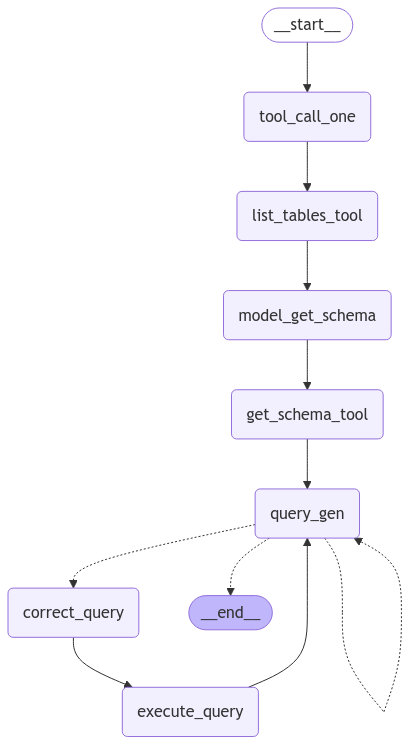

In [38]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [49]:
messages = app.invoke(
    {"messages": [("user", "How many different job roles ?")]}
)

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '\n<tool-use>\n{\n\t"tool_call": {\n\t\t"id": "pending",\n\t\t"type": "function",\n\t\t"function": {\n\t\t\t"name": "db_query_tool"\n\t\t},\n\t\t"parameters": {\n\t\t\t"query": "SELECT COUNT(\\*) FROM orders WHERE order\\_date BETWEEN \'2022-01-01\' AND \'2022-12-31\' AND status = \'completed\'"\n\t\t}\n\t}\n}\n</tool-use>'}}

In [48]:
json_str = messages["messages"][-1].tool_calls[0]["args"]["final_answer"]
json_str

'There are 3 different job roles: Manager, Engineer-1, and Tester.'